# Generate Configuration Files

In [4]:
def generate_config(starting_currencies={}, eclss_config={},
                    plants=[], habitat='medium', greenhouse='medium'):
    
    # Default fields
    priorities = ['structures', 'storage', 'power_generation', 
                  'inhabitants', 'eclss', 'plants']
    config = dict(seed=12345,
                  agents={},
                  termination=[],
                  single_agent=1,
                  priorities=priorities)
    
    # Helper functions
    def _add_agent(agent_type, amount=1, **kwargs):
        """Add agent to config"""
        currencies = kwargs.get('currencies', {})
        total_capacity = kwargs.get('total_capacity', None)
        agent_id = kwargs.get('agent_id', 1)
        config['agents'][agent_type] = {'amount': amount,
                                        'id': agent_id,
                                        'total_capacity': total_capacity,
                                        **currencies}
    def atmosphere(volume):
        """Return currencies for earth-normal atmosphere of given volume"""
        AIR_DENSITY = 1.25
        mass = volume * AIR_DENSITY
        percentages = { "n2": 78.084,  # nitrogen
                        "o2": 20.946,  # oxygen
                        "co2": 0.041332,  # carbon dioxide
                        "ch4": 0.000187,  # methane
                        "h2": 0.000055,  # hydrogen
                        "h2o": 1}  # water vapor
        return dict({k: mass*v/100 for k, v in percentages.items()},
                    total_capacity=dict(value=mass, unit='kg'))
    
    # Basic Agents
    _add_agent('solar_pv_array_mars', amount=1000)
    _add_agent('power_storage', currencies=dict(kwh=starting_currencies.get('kwh', 1000)))
    _add_agent('water_storage', currencies=dict(potable=starting_currencies.get('potable', 3000)))
    _add_agent('nutrient_storage', currencies=dict(fertilizer=starting_currencies.get('fertilizer', 100)))
    _add_agent('co2_storage', currencies=dict(co2=starting_currencies.get('co2', 500)))
    
    # Humans
    habitat_volume = {'small': 1000, 'medium': 2260, 'large': 4020}[habitat]
    _add_agent('human_agent', 3)
    _add_agent(f'crew_habitat_{habitat}', currencies=atmosphere(habitat_volume))
    _add_agent('ration_storage', currencies=dict(ration=starting_currencies.get('rations', 1000)))
        
    # ECLSS
    eclss_amount = 2
    eclss_components = ['co2_removal_SAWD', 'co2_reduction_sabatier',
                        'dehumidifier', 'multifiltration_purifier_post_treatment',
                        'co2_makeup_valve', 'solid_waste_aerobic_bioreactor', 
                        'oxygen_generation_SFWE', 'urine_recycling_processor_VCD',
                        'ch4_removal_agent']
    if len(plants) > 0:
        eclss_components.append('atmosphere_equalizer')
    eclss = {a: eclss_config.get(a, eclss_amount) for a in eclss_components}
    for k, v in eclss.items():
        _add_agent(k, v)
    
    # Plants
    if len(plants) > 0:
        greenhouse_volume = {'small': 490, 'medium': 2454, 'large': 5610}[greenhouse]
        _add_agent(f'greenhouse_{greenhouse}', currencies=atmosphere(greenhouse_volume))
        _add_agent('food_storage')
        for (plant, amount) in plants:
            _add_agent(plant, amount)
    
    return config

In [5]:
def generate_agent_desc(target_ppm, ppm_buffer=100):
    """Return a custom agent_desc to maintain atmosphere at given co2 level"""
    agent_desc = {'eclss': {}}
    def _set_for_ppm(agent, ppm, buffer):
        agent_desc['eclss'][agent] = {
            'data': {
                'input': [
                    {
                        'type': 'co2',
                        'criteria': {
                            'value': ppm/1e6,
                            'buffer': buffer
                        }
                    }
                ]
            }
        }
    for agent in ['co2_removal_SAWD', 'co2_reduction_sabatier']:
        _set_for_ppm(agent, target_ppm+ppm_buffer, 2) # Remove co2 when above this level
    _set_for_ppm('co2_makeup_valve', target_ppm, 0) # Add co2 when below this level
    return agent_desc

In [6]:
import json

def update_connections():
    """Connect ECLSS components to greenhouse instead of habitat"""
    with open('data_files/default_agent_conn.json') as f:
        connections = json.load(f)
    comps = ['co2_removal_SAWD.co2', 'co2_reduction_sabatier.co2', 'dehumidifier.co2']
    for conn in connections:
        if conn['to'] in comps:
            conn['from'] = 'greenhouse.co2'
        elif conn['from'] == 'co2_makeup_valve.co2':
            conn['to'] = 'greenhouse.co2'
    with open('data_files/agent_conn.json', 'w') as f:
        json.dump(connections, f)

In [7]:
import json

def lifetime(plant):
    with open('data_files/agent_desc.json') as f:
        agent_desc = json.load(f)
        
    p_desc = agent_desc['plants'][plant]
    for c in p_desc['data']['characteristics']:
        if c['type'] == 'lifetime':
            return c['value']

# Display Data

In [5]:
import matplotlib.pyplot as plt

def plot_group(group, exclude=[], i=None, j=None):
    """Plot all values in a group (storage, flows, deprive or growth)"""
    plt.figure(figsize=(12,6))
    length = len(next(iter(group.values())))
    i = i if i else 0
    j = j if j else length-1
    steps = [i for i in range(j-i)]
    for currency, values in group.items():
        if sum(values) == 0 or currency in exclude:
            continue
        plt.plot(steps, values[i:j], label=currency)
    plt.legend()
    plt.show()

In [6]:
import matplotlib.pyplot as plt

def plot_currency(data, currency, exclude=[], i=None, j=None):
    """Plot all agents who use a particular currency"""
    
    # Iterate through data and extract all records
    flows = {}
    length = None
    for agent_name, agent_data in data.items():
        if 'flow_records' not in agent_data:
            continue
        for currency_name, currency_data in agent_data['flow_records'].items():
            if currency_name != currency:
                continue
            flow_records = {}
            if not length:
                length = len(currency_data)
            for n, step in enumerate(currency_data):
                # Steps can include records for multiple currencies, 
                # or multiple records for the same currency
                at_least_one = False
                for record in step:
                    if agent_name not in flows:
                        flows[agent_name] = [] + [0] * n
                    if not at_least_one:
                        at_least_one = True
                        flows[agent_name].append(-record['amount'])
                    else:
                        flows[agent_name][-1] -= record['amount']
                if not at_least_one and agent_name in flows:
                    flows[agent_name].append(0)
    
    if not length:
        print("No flow records for", currency)
        return
    
    # Plot data
    plt.figure(figsize=(12,6))
    i = i if i else 0
    j = j if j else length
    steps = [x for x in range(j-i)]
    for agent_name, agent_data in flows.items():
        if agent_name in exclude:
            continue
        pad_zeros = len(steps) - len(agent_data)
        if pad_zeros > 0:
            agent_data += [0] * pad_zeros
        plt.plot(steps, agent_data[i:j], label=agent_name)
    plt.legend(loc='lower right')
    plt.show()

# Scenarios

In [8]:
from agent_model import AgentModel

plant_ratios = dict(wheat=.27, peanut=.33, tomato=.2, radish=.2)

## Sizing

In [56]:
import json
from collections import defaultdict

with open('data_files/agent_desc.json') as f:
    agent_desc = json.load(f)
with open('data_files/currency_desc.json') as f:
    currency_desc = json.load(f)

# Get human co2 production
human = agent_desc['inhabitants']['human_agent']['data']
for flow in human['output']:
    if flow['type'] == 'co2':
        co2_production = flow['value']
        break
kcal_consumption = 3104/24  # per NASA BVAD
        
# Get garden unit co2 consumption and food production
macros = ['protein', 'carbohydrate', 'fat']
co2_consumption, kcal = 0, {}
biomass_production, edible_fraction = {}, {}
food_production, food_nutrition = {}, {}
edible_fraction = {}
for plant, ratio in plant_ratios.items():
    plant_data = agent_desc['plants'][plant]['data']
    co2 = [f['value'] for f in plant_data['input'] if f['type'] == 'co2'][0]
    co2_consumption += co2 * ratio
    
    step_biomass = [f['value'] for f in plant_data['output'] if f['type'] == 'biomass'][0]
    biomass_production[plant] = step_biomass
    edible_portion = [f['value'] for f in plant_data['output'] if f['type'] == plant][0]
    edible_fraction[plant] = edible_portion
    food = step_biomass * edible_portion
    food_production[plant] = food * ratio
    
    food_data = currency_desc['food'][plant]
    kcal[plant] = food_data['nutrition']['kcal']
    food_nutrition[plant] = {m: food_data['nutrition'][m] for m in macros}
        
# Calculate area required to offset co2
offset_area = round(co2_production / co2_consumption, 1)
print(f'humans produce {co2_production} kg/hr of co2.')
print(f'plants consume {co2_consumption} kg/hr.')
print(f'{offset_area} m2 of garden offsets human production.')
print('----')

# Calculate area required to offset food
kcal_production = sum([food_production[p] * kcal[p] for p in plant_ratios])
full_area = round(kcal_consumption / kcal_production, 1)
print(f'humans consume {kcal_consumption} kcal/hr')
print(f'plants produce {total_food} kg/hr, which is {kcal_production} kcal.')
print(f'{full_area} m2 of garden offsets human consumption.')
print('----')

# Calculate macronutrient distribution of food
total_nutrition = {m: 0 for m in macros}
for plant, nutrition in food_nutrition.items():
    food_ratio = food_production[plant] / total_food
    for k, v in nutrition.items():
        total_nutrition[k] += v * food_ratio
total_macros = sum(total_nutrition.values())
for k, v in total_nutrition.items():
    print(k, round(v/total_macros*100, 2), '%')
    
# Calculate the net edible/inedible ratio
print('----')
total_biomass = 0
for plant, ratio in plant_ratios.items():
    biomass = biomass_production[plant]
    total_biomass += biomass * ratio
print(f'Plants produce {total_biomass} kg/hr biomass.')
print(f'This results in {total_food} kg edible food.')
print(f'Net edible ratio is {total_food/total_biomass}.')

humans produce 0.045 kg/hr of co2.
plants consume 0.001614023757404 kg/hr.
27.9 m2 of garden offsets human production.
----
humans consume 129.33333333333334 kcal/hr
plants produce 0.0004351617828308 kg/hr, which is 1.2855414707766841 kcal.
100.6 m2 of garden offsets human consumption.
----
protein 18.09 %
carbohydrate 65.05 %
fat 16.86 %
----
Plants produce 0.00115676199 kg/hr biomass.
This results in 0.0004351617828308 kg edible food.
Net edible ratio is 0.37618955895222667.


## 'Base': 3 Humans + regular ECLSS

In [13]:
# Base: 3 humans + regular ECLSS
config = generate_config()
agent_desc = generate_agent_desc(350)
model = AgentModel.from_config(config, data_collection=True, agent_desc=agent_desc)
model.step_to(n_steps=5000)
data = model.get_data(debug=True)
with open('simdata_base.json', 'w') as f:
    json.dump(data, f)

## 'Offset': 3 humans + garden scaled to offset human CO2 production

In [14]:
# Offset: 3 humans + garden, scaled to CO2
garden_size = 84
plants = [(k, v*garden_size) for k, v in plant_ratios.items()]
config = generate_config(plants=plants, greenhouse='medium')
update_connections()
for ppm in [350, 700]:
    agent_desc = generate_agent_desc(ppm, ppm_buffer=100)
    model = AgentModel.from_config(config, data_collection=True, agent_desc=agent_desc)
    model.step_to(n_steps=5000)
    data = model.get_data(debug=True)
    with open(f'simdata_offset_{ppm}.json', 'w') as f:
        json.dump(data, f)

## 'Full': 3 humans + garden scaled to offset human food consumption

In [9]:
# Full: 3 humans + garden, scaled to food
garden_size = 302
plants = [(k, v*garden_size) for k, v in plant_ratios.items()]
eclss_config = {'co2_removal_SAWD': 5, 'co2_makeup_valve': 20}
currencies = {'co2': 2500}
update_connections()
config = generate_config(plants=plants, greenhouse='large', 
                         eclss_config=eclss_config, starting_currencies=currencies)
for ppm in [350, 700]:
    agent_desc = generate_agent_desc(ppm, ppm_buffer=200)
    model = AgentModel.from_config(config, data_collection=True, agent_desc=agent_desc)
    model.step_to(n_steps=5000)
    data = model.get_data(debug=True)
    with open(f'simdata_full_{ppm}.json', 'w') as f:
        json.dump(data, f)

KeyboardInterrupt: 

## Expected CO2 Consumption

In [10]:
garden_size = 100
plants = [(k, v*garden_size) for k, v in plant_ratios.items()]
update_connections()
config = generate_config(plants=plants)
model = AgentModel.from_config(config)

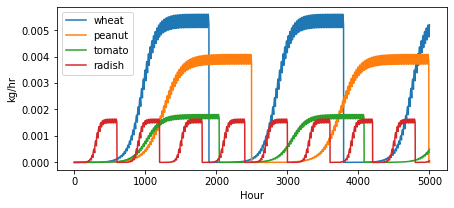

In [11]:
import matplotlib.pyplot as plt
import numpy as np

length = 5001
steps = [i for i in range(length)]
plt.figure(figsize=(7, 3))
for p in plant_ratios.keys():
    plant = model.get_agents_by_type(p)[0]
    co2 = list(plant.step_values['in_co2'])
    while len(co2) < length:
        co2 = co2 + co2
    plt.plot(steps, co2[:length], label=p)
# plt.title('Expected CO2 Consumption')
plt.xlabel('Hour')
plt.ylabel('kg/hr')
plt.legend(loc='upper left')
plt.show()

## Expected Flows

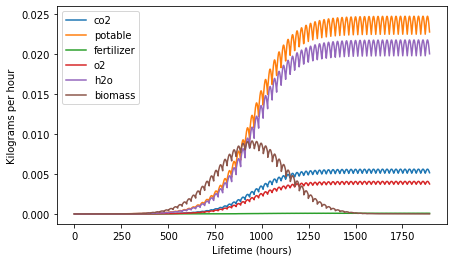

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
wheat = model.get_agents_by_type('wheat')[0]
steps = [i for i in range(lifetime('wheat'))]
exclude = ['in_biomass', 'out_wheat', 'out_inedible_biomass', 'in_kwh']
for item, values in wheat.step_values.items():
    if item in exclude:
        continue
    name = item.split('_')[1]
    plt.plot(steps, values, label=name)
plt.legend()
plt.ylabel('Kilograms per hour')
plt.xlabel('Lifetime (hours)')
plt.show()

In [ ]:
p